# Model Evaluation

## Import Libraries

In [12]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import cv2

from src.paths import model_dir, data_dir

## Load Model

In [13]:
model = load_model(model_dir / "best_model.keras")

## Load and Prepare Datasets

In [14]:
test_df = pd.read_csv(data_dir / "Test.csv")
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [18]:
import cv2
import numpy as np
from pathlib import Path

test_images = []
test_labels = []
skipped_images = []

for _, row in test_df.iterrows():
    image_path = data_dir / row["Path"]
    image = cv2.imread(str(image_path))

    if image is None:
        print(f"Could not read image at: {'/'.join(image_path.parts[-2:])}")
        skipped_images.append(image_path)
        continue

    image = image.astype("float32") / 255.0
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (64, 64))
    test_images.append(image)
    test_labels.append(row["ClassId"])

# Convert to NumPy arrays and normalize
x_test = np.array(test_images)
y_test = np.array(test_labels)

# Sanity check
assert len(x_test) == len(y_test), "Mismatch between images and labels"

# Report
print(f"\nSuccessfully loaded {len(x_test)} images out of {len(test_df)}")
if skipped_images:
    print(f"Skipped {len(skipped_images)} corrupted image(s):")
    for path in skipped_images:
        print(f"{'/'.join(path.parts[-2:])}")

Could not read image at: Test/00802.png

Successfully loaded 12629 images out of 12630
Skipped 1 corrupted image(s):
Test/00802.png


## Predict Outputs

In [19]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


## Confusion Matrix & Report

Test Accuracy: 0.059307942038166125

 Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.50      0.63        60
           1       0.91      0.97      0.94       720
           2       0.00      0.00      0.00       750
           3       0.00      0.00      0.00       450
           4       0.00      0.00      0.00       660
           5       0.00      0.00      0.00       629
           6       0.00      0.00      0.00       150
           7       0.00      0.00      0.00       450
           8       0.00      0.00      0.00       450
           9       0.00      0.00      0.00       480
          10       0.00      0.00      0.00       660
          11       0.00      0.00      0.00       420
          12       0.00      0.00      0.00       690
          13       0.00      0.00      0.00       720
          14       0.00      0.00      0.00       270
          15       0.00      0.00      0.00       210
          16       

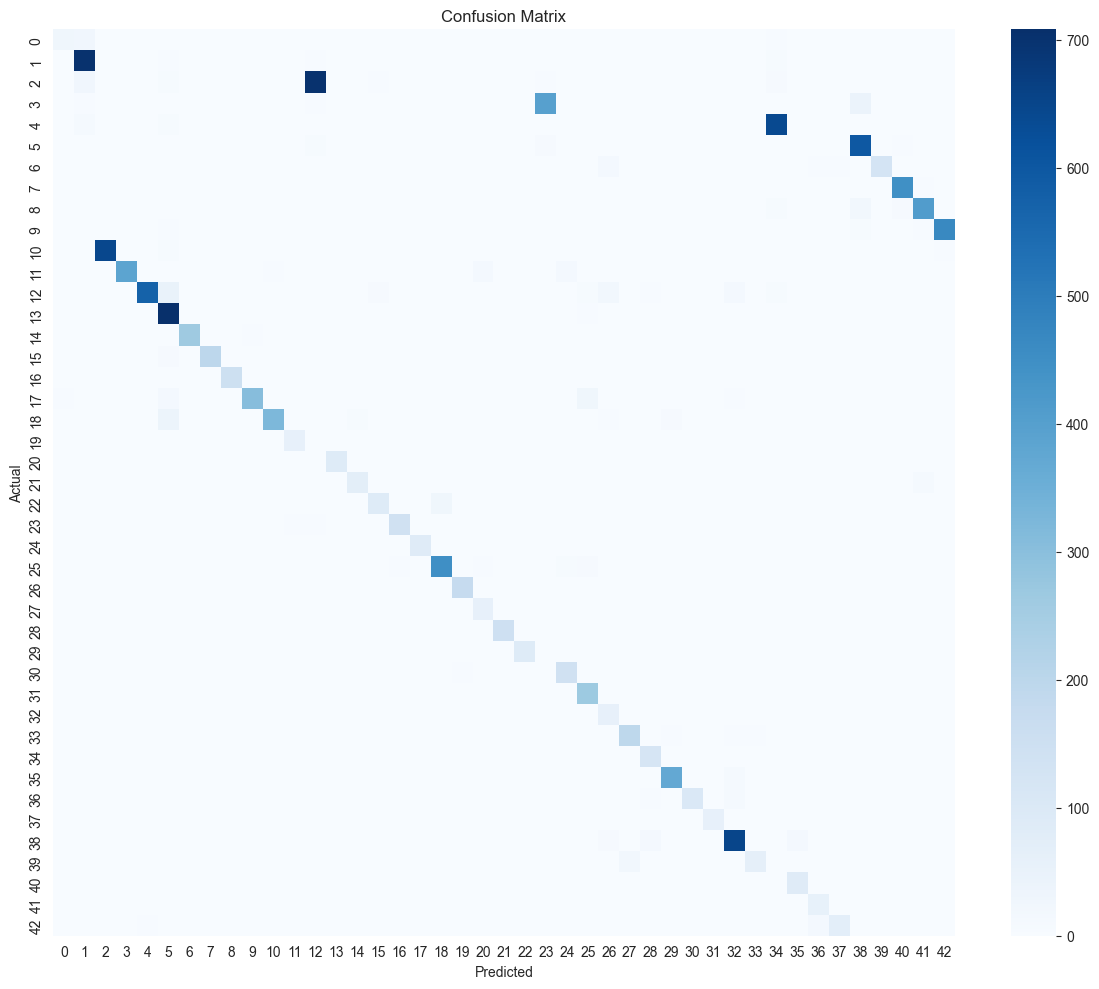

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()